<a href="https://colab.research.google.com/github/masoudshahrian/Deep-learning-code/blob/main/facedetection_with_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob

In [ ]:
# Set your image dataset
path="/content/drive/MyDrive/Imagetest"

# Load and preprocess the dataset
def load_images(path, img_size=(64, 64)):  #Reduce image size
    images = []
    for file in glob.glob(path + "/*.jpg"):
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, img_size)
        images.append(img)
    return np.array(images)


# Load and preprocess the new image
def load_and_preprocess_image(image_path, img_size=(64, 64)):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, img_size)
    return img


# تقسیم تصاویر به دو نیمه
def split_images(images):
    upper_half = []
    lower_half = []
    for img in images:
        h, w, _ = img.shape
        upper_half.append(img[:h//2, :])
        lower_half.append(img[h//2:, :])
    return np.array(upper_half), np.array(lower_half)


# Split the image into upper and lower halves
def split_image(img):
    h, w, _ = img.shape
    upper_half = img[:h//2, :]
    return upper_half


# Combine 2 halfs of image and create complete image
def combine_and_display(upper_half, lower_half_pred):
    full_face = np.vstack((upper_half, lower_half_pred))
    plt.imshow(full_face)
    plt.axis('off')
    plt.show()


# Load and preprocessing
path_to_images =path  # "/path/to/your/dataset"  # Your imege dataset path
images = load_images(path_to_images)
upper_half, lower_half = split_images(images)

# Normalizing Data
upper_half = upper_half / 255.0
lower_half = lower_half / 255.0

# Initiate autoencoder
input_shape = upper_half.shape[1:]

encoder_input = layers.Input(shape=input_shape)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Flatten()(x)

encoder_output = layers.Dense(256, activation='relu')(x)  # Number of nodes

encoder = models.Model(encoder_input, encoder_output)


In [ ]:
# encoder_inp////////ut
encoder_output

<KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'dense')>

Epoch 1/500
148/148 [==============================] - 9s 12ms/step - loss: 0.0434 - val_loss: 0.0323
Epoch 2/500
148/148 [==============================] - 1s 7ms/step - loss: 0.0294 - val_loss: 0.0260
Epoch 3/500
148/148 [==============================] - 1s 8ms/step - loss: 0.0249 - val_loss: 0.0255
Epoch 4/500
148/148 [==============================] - 1s 8ms/step - loss: 0.0220 - val_loss: 0.0227
Epoch 5/500
148/148 [==============================] - 1s 8ms/step - loss: 0.0191 - val_loss: 0.0203
Epoch 6/500
148/148 [==============================] - 1s 8ms/step - loss: 0.0171 - val_loss: 0.0186
Epoch 7/500
148/148 [==============================] - 1s 9ms/step - loss: 0.0152 - val_loss: 0.0178
Epoch 8/500
148/148 [==============================] - 1s 9ms/step - loss: 0.0138 - val_loss: 0.0166
Epoch 9/500
148/148 [==============================] - 1s 10ms/step - loss: 0.0123 - val_loss: 0.0159
Epoch 10/500
148/148 [==============================] - 1s 8ms/step - loss: 0.0114 - val_

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


164/164 [==============================] - 1s 3ms/step


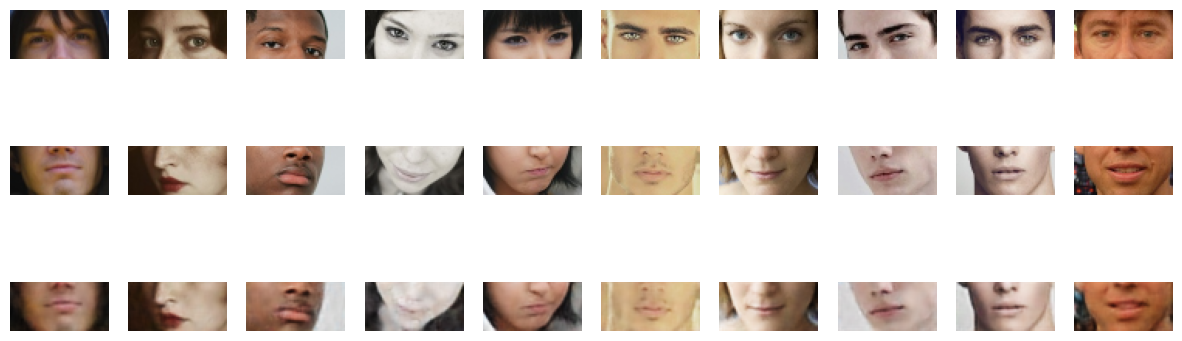

1/1 [==============================] - 0s 380ms/step


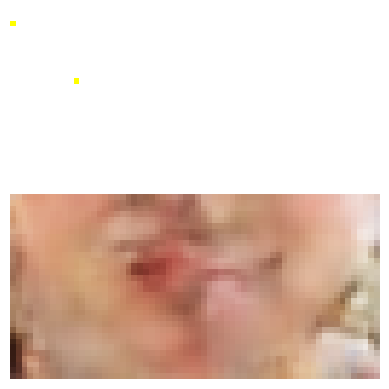

In [ ]:

decoder_input = layers.Input(shape=(256,))  # Decoder number
x = layers.Dense(encoder_output.shape[1], activation='relu')(decoder_input)
x = layers.Dense((input_shape[0]//4) * (input_shape[1]//4) * 64, activation='relu')(x)
x = layers.Reshape((input_shape[0]//4, input_shape[1]//4, 64))(x)
x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoder_output = layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(x)

decoder = models.Model(decoder_input, decoder_output)

autoencoder_input = layers.Input(shape=input_shape)
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)

autoencoder = models.Model(autoencoder_input, decoded_img)
autoencoder.compile(optimizer='adam', loss='mse')

# Training model
autoencoder.fit(upper_half, lower_half, epochs=500, batch_size=32, validation_split=0.1)  # Epoch & batch size

# ذخیره مدل
autoencoder.save('autoencoder_model.h5')

# Showing results
def display_results(model, upper_half, lower_half):
    predictions = model.predict(upper_half)
    fig, axes = plt.subplots(3, 10, figsize=(15, 5))
    for i in range(10):
        axes[0, i].imshow(upper_half[i])
        axes[0, i].axis('off')
        axes[1, i].imshow(lower_half[i])
        axes[1, i].axis('off')
        axes[2, i].imshow(predictions[i])
        axes[2, i].axis('off')
    plt.show()

display_results(autoencoder, upper_half, lower_half)



# # ذخیره مدل
autoencoder.save('autoencoder_model.h5')

# بارگذاری مدل و انجام پیش‌بینی
loaded_model = tf.keras.models.load_model('autoencoder_model.h5')

# Path to the new image
image_path ="/content/test1.png" #"/content/resized_image.jpg"# "/path/to/new/image.jpg"  # مسیر تصویر جدید

# Load and preprocess the new image
new_image = load_and_preprocess_image(image_path)
upper_half = split_image(new_image)

# Normalize the upper half
upper_half_normalized = upper_half / 255.0

# Predict the lower half using the model
upper_half_normalized = np.expand_dims(upper_half_normalized, axis=0)  # Add batch dimension
lower_half_pred = loaded_model.predict(upper_half_normalized)[0]

# Combine the upper and predicted lower halves and display the full face
combine_and_display(upper_half, lower_half_pred)



In [ ]:
# autoencoder.save('autoencoder_model.h5')


1/1 [==============================] - 0s 245ms/step


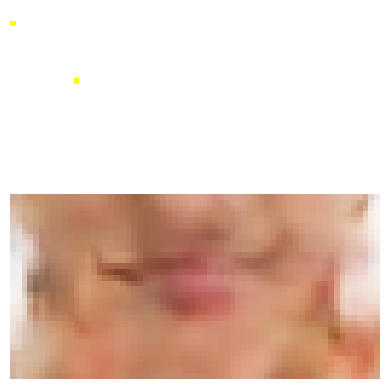

In [ ]:
# Load and preprocess the new image
def load_and_preprocess_image(image_path, img_size=(64, 64)):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, img_size)
    return img

# Split the image into upper and lower halves
def split_image(img):
    h, w, _ = img.shape
    upper_half = img[:h//2, :]
    return upper_half

# ترکیب نیمه بالا و پایین و نمایش تصویر کامل
def combine_and_display(upper_half, lower_half_pred):
    full_face = np.vstack((upper_half, lower_half_pred))
    plt.imshow(full_face)
    plt.axis('off')
    plt.show()

# Load the trained model
loaded_model = tf.keras.models.load_model('autoencoder_model.h5')

# Path to the new image
image_path = "/content/test1.png"  # مسیر تصویر جدید

# Load and preprocess the new image
new_image = load_and_preprocess_image(image_path)
upper_half = split_image(new_image)

# Normalize the upper half
upper_half_normalized = upper_half / 255.0

# Predict the lower half using the model
upper_half_normalized = np.expand_dims(upper_half_normalized, axis=0)  # Add batch dimension
lower_half_pred = loaded_model.predict(upper_half_normalized)[0]

# Combine the upper and predicted lower halves and display the full face
combine_and_display(upper_half, lower_half_pred)
